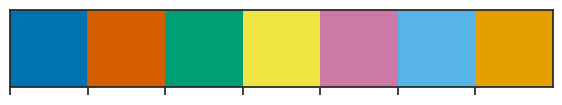

In [1]:
import sys
import os
import re
from glob import glob
import random
import itertools as it
import warnings
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans


## Default plotting params

%matplotlib inline
sns.set(font='Arial')
plt.rcParams['svg.fonttype'] = 'none'
style = sns.axes_style('white')
style.update(sns.axes_style('ticks'))
style['xtick.major.size'] = 1
style['ytick.major.size'] = 1
sns.set(font_scale=1, style=style)
pal = sns.color_palette(['#0072b2', '#d55e00', '#009e73', '#f0e442', '#cc79a7', '#56b4e9', '#e69f00'])
cmap = ListedColormap(pal.as_hex())
sns.set_palette(pal)
sns.palplot(pal)
plt.show()

In [2]:
cb_stats = pd.read_csv('../../pipeline/ext_data/ichino_metadata.csv.gz', sep=',', index_col=0).query('sample.str.startswith("Col0")')
cb_stats['cell_type'] = cb_stats['nucleus.cat'].map(
    {
        'veg': 'Soma',
        'VNearly': 'Vegetative (immature)',
        'VNlate': 'Vegetative (mature)',
        'MN': 'Microspore',
        'GN': 'Generative',
        'SN': 'Sperm',
        'trans': 'Transitory'
    }
)

umap= pd.read_csv('../../pipeline/ext_data/ichino_UMAP_coord.csv', sep=',', index_col=0)
cb_stats = cb_stats.join(umap)
cb_stats.head()

order = ['Soma', 'Transitory', 'Microspore', 'Vegetative (immature)', 'Generative', 'Vegetative (mature)', 'Sperm']

In [3]:
dtypes = defaultdict(lambda: np.float16)
dtypes[0] = str
count_data = pd.concat((
    pd.read_csv(fn, sep='\t', dtype=dtypes, index_col=0)
    for fn in glob('../../pipeline/ext_data/*_counts_matrix.txt.gz')
), axis=1)

MemoryError: Unable to allocate 676. MiB for an array with shape (9277, 38211) and data type float16

In [ ]:
def plot_umap_gene_exprs(gene_id, vmin=1, vmax=5):
    cdata = np.log2(count_data.loc[gene_id])
    exprs_mask = cdata > vmin
    exprs_idx = cdata.loc[exprs_mask].index
    no_exprs_idx = cdata.loc[~exprs_mask].index
    fig, ax = plt.subplots(figsize=(6.3, 5))
    sns.scatterplot(
        x='UMAP_1', y='UMAP_2',
        color='#dddddd',
        data=cb_stats.loc[no_exprs_idx],
        alpha=0.2,
        size=1,
        edgecolor='none',
        rasterized=True,
        ax=ax
    )
    sns.scatterplot(
        x='UMAP_1', y='UMAP_2',
        hue=cdata.loc[exprs_idx],
        palette='Blues',
        data=cb_stats.loc[exprs_idx],
        hue_norm=(1, vmax),
        rasterized=True,
        alpha=0.2,
        size=1,
        edgecolor='none',
        ax=ax
    )
    for label, x, y in cb_stats.groupby('cell_type').agg({'UMAP_1': 'mean', 'UMAP_2': 'mean'}).itertuples():
        ax.annotate(text=label, xy=(x, y), va='center', ha='center')
    ax.legend_.remove()
    norm = plt.Normalize(vmin, vmax)
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])
    cax = ax.figure.colorbar(mappable=sm, ax=ax)
    cax.ax.set_ylabel('Log2 gene expression')
    ax.set_xlabel('UMAP component 1')
    ax.set_ylabel('UMAP component 2')
    return fig, ax


In [ ]:
fig, ax = plot_umap_gene_exprs('AT2G36020', vmax=2)
plt.show()

/netscratch/dep_mercier/grp_schneeberger/bin/bin_matt/conda_envs/nb_rpy2/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


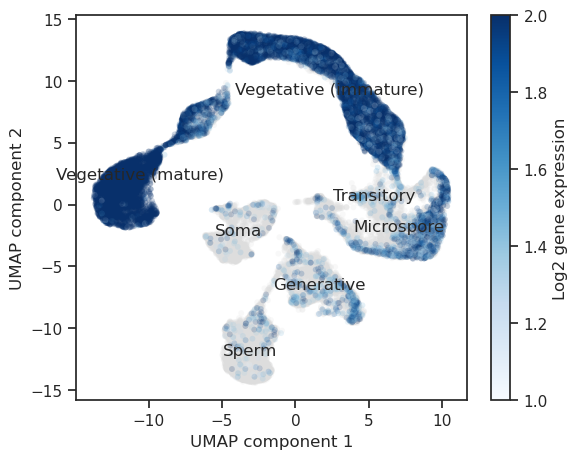

In [32]:
fig, ax = plot_umap_gene_exprs('AT4G36690', vmax=2)
plt.show()